In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
from modules.function import get_elem_count, alt_read_gfa_dataset, check_cuda, get_metrics, image, read_gfa_dataset
from modules.representation_schemes import get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features, get_random_features, get_random_features_dense, random_order_alpha, get_1D_features_gfa, get_dense_features_gfa
from modules.encoder import Encoder1D, EncoderDNN, Encoder
import re
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import joblib
import random
import torch
import pickle
from decimal import Decimal
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import combinations
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from itertools import cycle
import sklearn.metrics as metrics

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
np.random.seed(0)
kfold_loc = 'misc/CV_folds/gfa_kfold.pkl'
create_new = False
if os.path.exists(kfold_loc) and not create_new:
    with open(kfold_loc,'rb') as fid:
        fold_dict = pickle.load(fid)
    print('Fold dictionary loaded!')
else:
    fold_dict = {}
    X, y, _ = get_dense_features_gfa()
    kfold = StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)
    for i,(train_index, test_index) in enumerate(kfold.split(X, y)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        fold_dict[i] = {'train_inds':train_index, 'test_inds':test_index}
    with open(kfold_loc,'wb') as fid:
        pickle.dump(fold_dict,fid)
    print('Fold dictionary created!')

Fold dictionary loaded!


In [ ]:
saveloc = 'saved_models/Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
if os.path.exists('results/gfa_predict_results.json'):
    with open('results/gfa_predict_results.json','rb') as fid:
        sup_metrics_dict = json.load(fid)
else:
    sup_metrics_dict = {}
for method in methods:
    print('Method : {}'.format(method))
    metrics_list = {}
    if method == 'dense':
        X, y, p = get_dense_features_gfa()    
    elif method in ['atomic','pettifor','mod_pettifor','random']:
        X, y, p = get_1D_features_gfa(method)    
    elif method == 'PTR':
        X, y, p = read_gfa_dataset()
    for i in fold_dict.keys():
        i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
        X_train, X_test = X[i_tr], X[i_te]
        y_train, y_test = y[i_tr], y[i_te]
        p_train, p_test = p[i_tr], p[i_te]
        batch = 64
        Xy = [(X_train[i],y_train[i],p_train[i]) for i in range(len(y_train))]
        train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
        if method in ['atomic','pettifor','mod_pettifor','random','random-tr']:
            type = 0
            encoder = Encoder1D(1,1)
        elif method == 'dense':
            type = 1
            encoder = EncoderDNN(X.shape[-1],3,42,1)
        else:
            type = 2
            encoder = Encoder(1,1)
        e_optimizer = optim.Adam(encoder.parameters(),lr = 2e-4)
        num_iterations = 2000
        cuda = check_cuda()
        if cuda:
            encoder = encoder.cuda()
        log_interval = int(5e2)
        for iter in tqdm.notebook.tqdm(range(num_iterations)):
            train_loss = 0.0
            for data in train_loader:
                X_temp, y_temp, p_temp = data
                if cuda:
                    X_temp = X_temp.cuda()
                    y_temp = y_temp.cuda()
                    p_temp = p_temp.cuda()
                e_optimizer.zero_grad()
                target = encoder(X_temp,p_temp)
                if cuda:
                    target = target.cuda()
                e_error = torch.nn.BCELoss()(target,y_temp)
                e_error.backward(retain_graph=True)
                e_optimizer.step()
                train_loss += e_error.cpu().item()
            if iter == 0 or (iter + 1) % log_interval == 0:  
                print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))
        spec_saveloc = os.path.join(saveloc,method)
        if not os.path.exists(spec_saveloc):
            os.makedirs(f'{spec_saveloc}')
        model_scripted = torch.jit.script(encoder.cpu())
        model_scripted.save(os.path.join(spec_saveloc,'Encoder{}D_{}_fold{}.pt'.format(type,method,i)))
        if X_test.dtype != torch.float32:
            X_test = torch.from_numpy(X_test)
        if p_test.dtype != torch.float32:
            p_test = torch.from_numpy(p_test)
        with torch.no_grad():
            y_predict = (encoder(X_test,p_test)).to('cpu').detach().numpy()
        metrics = get_metrics(y_test,np.round(y_predict))
        metrics_list[i] = metrics
        print('accuracy : {},precision : {},recall : {},F1 : {}'.format(metrics[0],metrics[1],metrics[2],metrics[3]))
    sup_metrics_dict[method] = metrics_list
    with open('results/gfa_predict_results.json','w') as f:
        json.dump(sup_metrics_dict,f)

Method : pettifor


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.90075674653053
Epoch : 500, Loss : 47.41315748542547
Epoch : 1000, Loss : 39.04890165477991
Epoch : 1500, Loss : 34.580145344138145
Epoch : 2000, Loss : 31.6621140409261
accuracy : 0.9305,precision : 0.9395,recall : 0.9305,F1 : 0.9319


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.61553889513016
Epoch : 500, Loss : 43.71593451872468
Epoch : 1000, Loss : 37.408181730657816
Epoch : 1500, Loss : 34.29116191342473
Epoch : 2000, Loss : 31.291627479717135
accuracy : 0.954,precision : 0.954,recall : 0.954,F1 : 0.954


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 181.50287893414497
Epoch : 500, Loss : 47.64289167523384
Epoch : 1000, Loss : 40.09151500090957
Epoch : 1500, Loss : 36.491026896983385
Epoch : 2000, Loss : 33.61237294971943
accuracy : 0.9358,precision : 0.9354,recall : 0.9358,F1 : 0.9355


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.2689170241356
Epoch : 500, Loss : 42.4481703825295
Epoch : 1000, Loss : 36.67925471998751
Epoch : 1500, Loss : 32.29613232426345
Epoch : 2000, Loss : 29.30786982178688
accuracy : 0.9435,precision : 0.945,recall : 0.9435,F1 : 0.9439


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.4973328113556
Epoch : 500, Loss : 44.62992645427585
Epoch : 1000, Loss : 37.59738098829985
Epoch : 1500, Loss : 34.06299205031246
Epoch : 2000, Loss : 32.87629499472678
accuracy : 0.9506,precision : 0.9506,recall : 0.9506,F1 : 0.9506


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.05044323205948
Epoch : 500, Loss : 43.97743344679475
Epoch : 1000, Loss : 36.73842753842473
Epoch : 1500, Loss : 33.18010549619794
Epoch : 2000, Loss : 31.244933078065515
accuracy : 0.9569,precision : 0.9572,recall : 0.9569,F1 : 0.957


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.19589725136757
Epoch : 500, Loss : 47.29554036259651
Epoch : 1000, Loss : 38.73413847759366
Epoch : 1500, Loss : 34.65378001332283
Epoch : 2000, Loss : 31.92637605406344
accuracy : 0.953,precision : 0.9539,recall : 0.953,F1 : 0.9533


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.14898803830147
Epoch : 500, Loss : 44.70187710225582
Epoch : 1000, Loss : 36.65000902861357
Epoch : 1500, Loss : 32.64293564297259
Epoch : 2000, Loss : 29.91153504513204
accuracy : 0.9598,precision : 0.9599,recall : 0.9598,F1 : 0.9598


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.51780450344086
Epoch : 500, Loss : 43.47242485359311
Epoch : 1000, Loss : 36.479143761098385
Epoch : 1500, Loss : 32.89013868570328
Epoch : 2000, Loss : 30.03786277398467
accuracy : 0.9372,precision : 0.9372,recall : 0.9372,F1 : 0.9372


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.98136976361275
Epoch : 500, Loss : 45.39493129774928
Epoch : 1000, Loss : 37.81093396991491
Epoch : 1500, Loss : 33.66395015269518
Epoch : 2000, Loss : 31.214686512947083
accuracy : 0.9463,precision : 0.9488,recall : 0.9463,F1 : 0.9469
Method : mod_pettifor


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.47921827435493
Epoch : 500, Loss : 48.53862750530243
Epoch : 1000, Loss : 41.08006849139929
Epoch : 1500, Loss : 36.576732371002436
Epoch : 2000, Loss : 33.54131286684424
accuracy : 0.9435,precision : 0.9432,recall : 0.9435,F1 : 0.9432


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.37032023072243
Epoch : 500, Loss : 47.816569201648235
Epoch : 1000, Loss : 40.49588767811656
Epoch : 1500, Loss : 36.07682237774134
Epoch : 2000, Loss : 33.591416005045176
accuracy : 0.9435,precision : 0.9442,recall : 0.9435,F1 : 0.9425


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.93928614258766
Epoch : 500, Loss : 40.4364077039063
Epoch : 1000, Loss : 33.561383390799165
Epoch : 1500, Loss : 29.005471389740705
Epoch : 2000, Loss : 26.27345934510231
accuracy : 0.9483,precision : 0.9489,recall : 0.9483,F1 : 0.9485


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.1602837741375
Epoch : 500, Loss : 44.56557109951973
Epoch : 1000, Loss : 35.946517154574394
Epoch : 1500, Loss : 32.146155409514904
Epoch : 2000, Loss : 29.01209623552859
accuracy : 0.9497,precision : 0.9495,recall : 0.9497,F1 : 0.9494


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.69371742010117
Epoch : 500, Loss : 42.36350305378437
Epoch : 1000, Loss : 34.67972498759627
Epoch : 1500, Loss : 31.2970851380378
Epoch : 2000, Loss : 28.518040923401713
accuracy : 0.9468,precision : 0.9473,recall : 0.9468,F1 : 0.947


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.96416300535202
Epoch : 500, Loss : 45.976089078933
Epoch : 1000, Loss : 39.37215223163366
Epoch : 1500, Loss : 34.49138744920492
Epoch : 2000, Loss : 31.56777430512011
accuracy : 0.9569,precision : 0.9567,recall : 0.9569,F1 : 0.9568


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.29251727461815
Epoch : 500, Loss : 45.582436215132475
Epoch : 1000, Loss : 37.70091849192977
Epoch : 1500, Loss : 32.91323193348944
Epoch : 2000, Loss : 29.57028693333268
accuracy : 0.942,precision : 0.9432,recall : 0.942,F1 : 0.9424


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.86990630626678
Epoch : 500, Loss : 46.00343880802393
Epoch : 1000, Loss : 38.16048371233046
Epoch : 1500, Loss : 35.21451596543193
Epoch : 2000, Loss : 31.653786858543754
accuracy : 0.9526,precision : 0.9524,recall : 0.9526,F1 : 0.9524


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 185.6348842382431
Epoch : 500, Loss : 42.01387791335583
Epoch : 1000, Loss : 35.608957272954285
Epoch : 1500, Loss : 30.81140192784369
Epoch : 2000, Loss : 27.774213396012783
accuracy : 0.9358,precision : 0.937,recall : 0.9358,F1 : 0.9362


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.620367705822
Epoch : 500, Loss : 44.992605494335294
Epoch : 1000, Loss : 39.577102329581976
Epoch : 1500, Loss : 34.11095293238759
Epoch : 2000, Loss : 31.01137255690992
accuracy : 0.9497,precision : 0.9496,recall : 0.9497,F1 : 0.9497
Method : PTR


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 186.64995807409286
Epoch : 500, Loss : 37.89843190833926
Epoch : 1000, Loss : 30.55020233243704
Epoch : 1500, Loss : 26.73209524154663
Epoch : 2000, Loss : 23.65032919216901
accuracy : 0.9569,precision : 0.9577,recall : 0.9569,F1 : 0.9571


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.04158666729927
Epoch : 500, Loss : 40.71879447251558
Epoch : 1000, Loss : 33.31877048872411
Epoch : 1500, Loss : 29.735022893175483
Epoch : 2000, Loss : 26.712443498894572
accuracy : 0.9444,precision : 0.9442,recall : 0.9444,F1 : 0.9439


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.37005650997162
Epoch : 500, Loss : 41.99622659012675
Epoch : 1000, Loss : 33.12807146832347
Epoch : 1500, Loss : 29.120072765275836
Epoch : 2000, Loss : 25.78766761533916
accuracy : 0.9382,precision : 0.9406,recall : 0.9382,F1 : 0.9388


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.3937732577324
Epoch : 500, Loss : 41.97946886718273
Epoch : 1000, Loss : 34.0192912761122
Epoch : 1500, Loss : 29.692536944523454
Epoch : 2000, Loss : 26.231100684963167
accuracy : 0.9449,precision : 0.9454,recall : 0.9449,F1 : 0.9451


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 183.2080545425415
Epoch : 500, Loss : 40.461649648845196
Epoch : 1000, Loss : 32.558499939739704
Epoch : 1500, Loss : 28.920481830835342
Epoch : 2000, Loss : 26.108193619176745
accuracy : 0.9334,precision : 0.9396,recall : 0.9334,F1 : 0.9345


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.89217740297318
Epoch : 500, Loss : 43.87083288654685
Epoch : 1000, Loss : 35.56743685901165
Epoch : 1500, Loss : 30.464659290388227
Epoch : 2000, Loss : 27.548158755525947
accuracy : 0.9598,precision : 0.9601,recall : 0.9598,F1 : 0.9599


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 184.1275569498539
Epoch : 500, Loss : 38.016774110496044
Epoch : 1000, Loss : 29.631517564877868
Epoch : 1500, Loss : 25.840258054435253
Epoch : 2000, Loss : 23.5465657254681
accuracy : 0.9516,precision : 0.9518,recall : 0.9516,F1 : 0.9517


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 182.79576587677002
Epoch : 500, Loss : 43.499575328081846


In [6]:
results_file = 'results/gfa_predict_results.json'
if os.path.exists(results_file):
    with open(results_file,'r') as fid:
        sup_metrics_dict = json.load(fid)

import shutil
saveloc = 'saved_models/Encoders'
best_model_loc = 'saved_models/best_models'
if not os.path.exists(best_model_loc):
    os.makedirs(f'{best_model_loc}')
for key in list(sup_metrics_dict.keys()):
    if key != 'ptr':
        col_names = ['Accuracy','Precision','Recall','F1 Score']
        stat_df = pd.DataFrame.from_dict(sup_metrics_dict[key],orient='index',columns=col_names)
        spec_saveloc = os.path.join(saveloc,key)
        best_ind = np.argwhere(stat_df['F1 Score'].values == np.max(stat_df['F1 Score'])).item()
        best_model_name = sorted(os.listdir(spec_saveloc))[best_ind]
        shutil.copy(os.path.join(spec_saveloc,best_model_name), os.path.join(best_model_loc,'1DEncoder_{}.pt'.format(key))) 

/tmp/ipykernel_552722/2780836352.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation = 45, fontsize = 14)


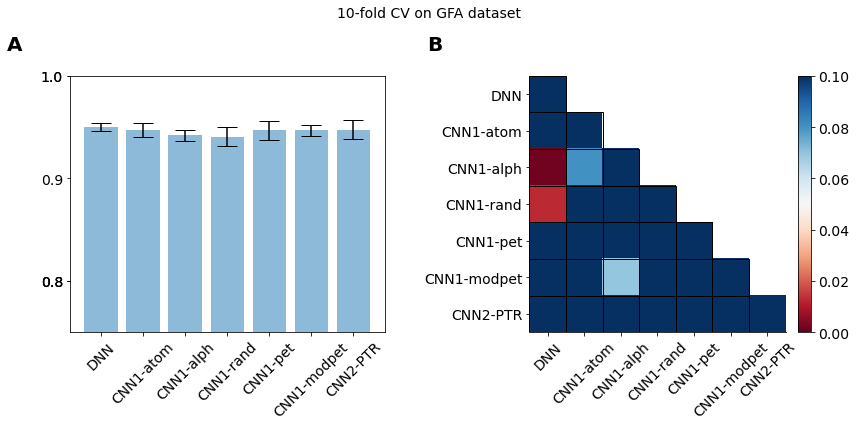

In [37]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']

compare_keys = combinations(methods,2)
zero = np.eye(len(methods))
for key in compare_keys:
    a,b = key
    ind1 = np.argwhere(np.array(methods)==a)
    ind2 = np.argwhere(np.array(methods)==b)
    a_score = np.array(list(sup_metrics_dict[a].values()))[:,-1]
    b_score = np.array(list(sup_metrics_dict[b].values()))[:,-1]
    zero[ind1,ind2] = ttest_ind(a_score,b_score)[-1]

mask =  np.tri(zero.T.shape[0], k=-1)
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

mean_list = []
std_list = []
for i, k in enumerate(methods):
        stat_arr = np.array(list(sup_metrics_dict[k].values()))
        mean_list.append(stat_arr.mean(axis=0))
        std_list.append(stat_arr.std(axis=0))
mean_list = np.array(mean_list).T
std_list = np.array(std_list).T

fig, axs = plt.subplot_mosaic("AB", figsize=(12,6))
for n, (key, ax) in enumerate(axs.items()):
        if n == 0:
                ax.bar(methods, mean_list[-1], yerr = std_list[-1],align='center', alpha=0.5, ecolor='black', capsize=10)
                ax.set(ylim=[0.75, 1])
                ax.set_xticklabels(names, rotation = 45, fontsize = 14)
                ax.set_yticks(np.round(np.arange(0.75,1.01,0.05),1), fontsize = 14, labels=np.round(np.arange(0.75,1.01,0.05),1))
                ax.text(-0.2, 1.1, key, transform=ax.transAxes, size=20, weight='bold')
        
        if n == 1:
                ax.set_xticks(np.arange(0, len(names), 1))
                ax.set_yticks(np.arange(0, len(names), 1))

                cmap = cm.get_cmap('RdBu')
                im = ax.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
                for i in range(len(truth[0])):
                        highlight_cell(truth[1][i],truth[0][i])
                diag = [0,1,2,3,4,5]
                for k in diag:
                        highlight_cell(k,k)
                ax.set_xticklabels(names, rotation = 45, fontsize = 14)
                ax.set_yticklabels(names, fontsize = 14)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(True)
                ax.spines['left'].set_visible(False)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                for t in cb.ax.get_yticklabels():
                        t.set_fontsize(14)
                ax.text(-0.4, 1.1, key, transform=ax.transAxes, 
                size=20, weight='bold')
    
plt.tight_layout()



fig.suptitle('10-fold CV on GFA dataset', fontsize = 14)
plt.tight_layout()

## Confusion matrix

In [58]:
from sklearn.metrics import confusion_matrix

methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']

conf_matrix_dict = {m:{} for m in methods}
for method in methods:
    cf_arr = np.zeros(4)
    folder_path = f'saved_models/Encoders/{method}'
    model_paths = sorted(os.listdir(folder_path))
    if method == 'dense':
        X, y, p = get_dense_features_gfa()    
    elif method in ['atomic','pettifor','mod_pettifor','random']:
        X, y, p = get_1D_features_gfa(method)    
    elif method == 'PTR':
        X, y, p = read_gfa_dataset()
    for i in fold_dict.keys():
        i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
        X_train, X_test = X[i_tr], X[i_te]
        y_train, y_test = y[i_tr], y[i_te]
        p_train, p_test = p[i_tr], p[i_te]
        encoder = torch.jit.load(os.path.join(folder_path,model_paths[i]),map_location='cpu')
        with torch.no_grad():
            y_pred = encoder(torch.from_numpy(X_test),torch.from_numpy(p_test))
        rounded_y_pred = np.round(y_pred.numpy())
        cf = confusion_matrix(rounded_y_pred, y_test).ravel()
        cf_arr += np.array(cf)
    conf_matrix_dict[method] = cf_arr.tolist()
with open('results/gfa_confusion_matrix.pkl', 'wb') as fid:
    pickle.dump(conf_matrix_dict,fid)

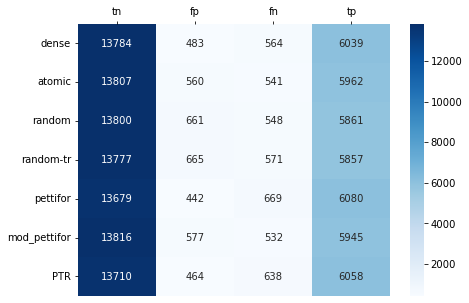

In [59]:
import seaborn as sns
fig,ax =plt.subplots(figsize = (7,5))
cf_df = pd.DataFrame.from_dict(conf_matrix_dict, orient='index', columns=('tn', 'fp', 'fn', 'tp'))
ax = sns.heatmap(cf_df, annot=True, cmap='Blues',fmt='g')

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

## ROC-AUC curve

In [77]:
import sklearn.metrics as metrics

methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']

roc_scores_dict = {m:{} for m in methods}
for method in methods:
    cf_arr = np.zeros(4)
    folder_path = f'saved_models/Encoders/{method}'
    model_paths = sorted(os.listdir(folder_path))
    if method == 'dense':
        X, y, p = get_dense_features_gfa()    
    elif method in ['atomic','pettifor','mod_pettifor','random']:
        X, y, p = get_1D_features_gfa(method)    
    elif method == 'PTR':
        X, y, p = read_gfa_dataset()
    y_pred_list = []
    y_test_list = []
    for i in fold_dict.keys():
        i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
        X_train, X_test = X[i_tr], X[i_te]
        y_train, y_test = y[i_tr], y[i_te]
        p_train, p_test = p[i_tr], p[i_te]
        encoder = torch.jit.load(os.path.join(folder_path,model_paths[i]),map_location='cpu')
        with torch.no_grad():
            y_pred = encoder(torch.from_numpy(X_test),torch.from_numpy(p_test))
        y_pred_list.extend(list(y_pred.numpy().ravel().tolist()))
        y_test_list.extend(list(y_test.ravel().tolist()))
    fpr, tpr, threshold = metrics.roc_curve(y_test_list, y_pred_list)
    roc_scores_dict[method] =  {'fpr':fpr, 'tpr':tpr, 'threshold':threshold}

with open('results/gfa_roc_auc.pkl', 'wb') as fid:
    pickle.dump(roc_scores_dict,fid)
        

/tmp/ipykernel_182532/2735199970.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(fpr, tpr, 'b', label =f'{key} AUC = %0.2f' % auc, c = next(cycol))
/tmp/ipykernel_182532/2735199970.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(fpr, tpr, 'b', label =f'{key} AUC = %0.2f' % auc, c = next(cycol))
/tmp/ipykernel_182532/2735199970.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(fpr, tpr, 'b', label =f'{key} AUC = %0.2f' % auc, c = next(cycol))
/tmp/ipykernel_182532/2735199970.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b"

Text(0.5, 0, 'False Positive Rate')

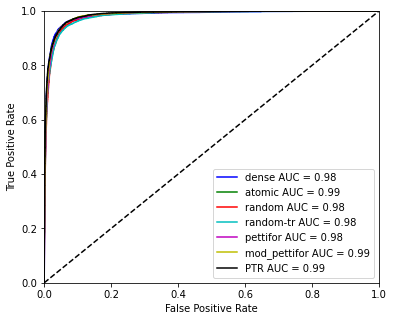

In [92]:
fig,ax = plt.subplots(figsize = (6,5))

from itertools import cycle
cycol = cycle("bgrcmykw")

for key in roc_scores_dict.keys():
    fpr = roc_scores_dict[key]['fpr']
    tpr = roc_scores_dict[key]['tpr']
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'b', label =f'{key} AUC = %0.2f' % auc, c = next(cycol))
plt.plot([0, 1], [0, 1],'k--')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
